### Downloading the NVIDIA Stock Dataset with `kagglehub`

The snippet below shows how to fetch a specific version of the NVIDIA stock history from Kaggle using the `kagglehub` library:


In [1]:
import kagglehub

# Download selected version
path = kagglehub.dataset_download("adilshamim8/nvidia-stock-market-history/versions/1")

print("Path to dataset files:", path)

Path to dataset files: /Users/yungtingsoo/.cache/kagglehub/datasets/adilshamim8/nvidia-stock-market-history/versions/1


In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import glob, os

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import linear_model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

### Locating and Selecting a CSV File

This snippet finds and validates the first CSV file in the downloaded dataset directory:


In [3]:
# Build a list of all CSV paths in the dataset folder
csv_paths = glob.glob(os.path.join(path, "*.csv"))
if not csv_paths:
    raise FileNotFoundError(f"No CSV files found in {path}")
csv_file = csv_paths[0]

### Loading the CSV into a Pandas DataFrame


In [4]:
df = pd.read_csv(csv_file, na_values=['null'], index_col='Date', parse_dates=True)
print(df.head())

               Close      High       Low      Open      Volume
Date                                                          
1999-01-22  0.037612  0.044775  0.035581  0.040119  2714688000
1999-01-25  0.041552  0.042029  0.037612  0.040597   510480000
1999-01-26  0.038328  0.042865  0.037731  0.042029   343200000
1999-01-27  0.038209  0.039403  0.036298  0.038447   244368000
1999-01-28  0.038089  0.038447  0.037850  0.038209   227520000


In [5]:
### Check for Any Missing Values in the DataFrame
df.isnull().values.any()

np.False_

In [6]:
### Inspecting the DataFrame’s Column Names
df.columns

Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')

<Axes: title={'center': 'NVIDIA Close Price'}, xlabel='Date'>

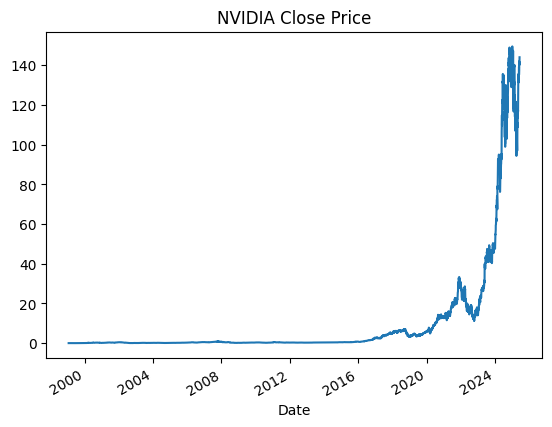

In [7]:
### Plotting the NVIDIA Closing Price Over Time

df['Close'].plot(title='NVIDIA Close Price')

In [8]:
### Defining the Target and Feature Sets

# Value of the stock at the end of the day to predict -- target variable
predict = pd.DataFrame(df['Close'])

# Features to use to predict the value of the stock -- input features
features = ['High', 'Low', 'Open', 'Volume']

### Normalizing Input Features with Min-Max Scaling
- **Why normalize?**
  - Neural networks (and many machine-learning algorithms) train more reliably and converge faster when all inputs share a similar scale. Here, we map each feature into the ```0,1``` range.

- **Steps explained**

  1. ```scaler = MinMaxScaler():```
     - Create a scaler that linearly transforms each feature so its minimum becomes 0 and its maximum becomes 1.
  2. ```scaler.fit_transform(df[features]):```
     - fit computes the min and max for each column in ```df[features]```.
     - transform applies the scaling to every value.
     - Returns a NumPy array of normalized values.
  4. ```pd.DataFrame(...):```
     - Wrap the scaled array back into a DataFrame, preserving the original column names and date index for easy alignment with our target series.
  5. ```features_normalised.head():```
     - Display the first few rows to confirm that each feature now lies between 0 and 1.

In [9]:
scaler = MinMaxScaler()
features_normalised = scaler.fit_transform(df[features])
features_normalised = pd.DataFrame(columns=features, data=features_normalised, index=df.index)
features_normalised.head()

,High,Low,Open,Volume
Date,,,,
1999-01-22,0.000080,0.000034,0.000053,0.292580
1999-01-25,0.000062,0.000048,0.000056,0.053283
1999-01-26,0.000067,0.000048,0.000066,0.035123
1999-01-27,0.000044,0.000039,0.000042,0.024393
1999-01-28,0.000038,0.000049,0.000041,0.022564
